# Домашнее задание 5

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 17 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_5

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию SGD:
$$
x^{k+1} = x^k - \gamma (\nabla f(x^k) + \xi^k),
$$
где $\xi^k$ - независимая от $x^k$ случайная величина из нормального распределения $\mathcal{N}(0, 100)$.

Для такого метода с $\gamma = \frac{1}{L}$ постройте график сходимости (критерий $\| \nabla f(x^k)\|^2$). Постройте на этом же графике сходимость честного градиентного спуска c $\gamma = \frac{1}{L}$. Сделайте вывод о характере сходимости нового метода.

In [1]:
import numpy as np
from math import log, exp, ceil, sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LinearRegression
import time 
from scipy.stats import special_ortho_group  
import matplotlib.gridspec as gridspec
import random

In [2]:
## Adding constants
L = 1000
mu = 1
gamma = 1/L
d = 100
E = np.eye(d)


In [3]:
def generate_matrix(d_local, mu_local, L_local):
    i = 0
    while i == 0:
        diagonal_entries = np.random.uniform(mu_local, L_local, d_local)
        diagonal_entries[0] = mu_local
        diagonal_entries[1] = L_local
        D = np.diag(diagonal_entries)
        m = special_ortho_group.rvs(d_local)
        A = (np.linalg.inv(m).dot(D)).dot(m)
        np.set_printoptions(suppress=True)
        if (is_pos_def(A-mu_local*E)):
            i += 1
    return A
    
def is_pos_def(x): #проверка положительной определённости
    return np.all(np.linalg.eigvals(x) > 0)

def gradient(x): 
    return A.dot(x) - b

In [4]:
start = np.ones(d)/d
A = generate_matrix(d, mu, L)
b = np.random.uniform(0, 10, d)

In [5]:
def gradient_descent(start, learn_rate, n_iter):
    values_x = []
    values_y = []
    vector = start
    vector_list = []
    begin_time = time.time()
    timeprogGDP = []
    grad = gradient(vector)
    for i in range(n_iter):
        vector = vector - learn_rate * (grad)
        grad = gradient(vector)
        values_x.append(i+1)
        values_y.append(grad.T.dot(grad))
        vector_list.append(vector)
        timeprogGDP.append(time.time() - begin_time)
    return values_x, values_y, vector, timeprogGDP

def gradient_descent_stokh(start, learn_rate, n_iter):
    values_x = []
    values_y = []
    vector = start
    vector_list = []
    begin_time = time.time()
    timeprogGDP = []
    grad = gradient(vector)
    for i in range(n_iter):
        vector = vector - learn_rate * (grad  + np.random.normal(0, 10, d))
        grad = gradient(vector)
        values_x.append(i+1)
        values_y.append(grad.T.dot(grad))
        vector_list.append(vector)
        timeprogGDP.append(time.time() - begin_time)
    return values_x, values_y, vector, timeprogGDP

In [6]:
values_x, values_y, vector, timeprogGDP = gradient_descent(np.ones(d)/d, 1/L, 10000)
values_x_1, values_y_1, vector_1, timeprogGDP_1 = gradient_descent_stokh(np.ones(d)/d, 1/L, 10000)

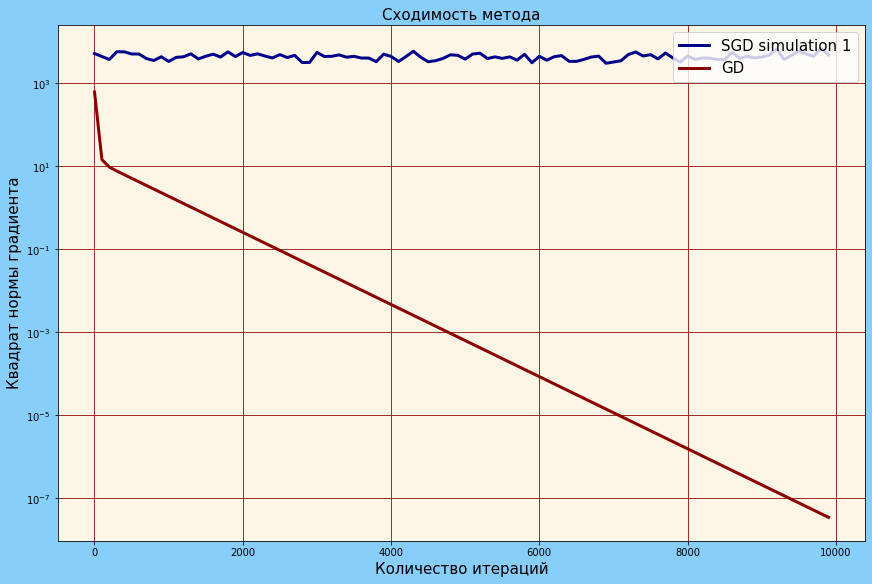

In [7]:
fg = plt.figure(figsize=(12, 8), constrained_layout=True, facecolor = "lightskyblue")
fig_ax_1 = fg.add_subplot(facecolor = "oldlace")
fig_ax_1.plot(values_x_1[::100], values_y_1[::100], 'darkblue', label = 'SGD simulation 1', linewidth=3)
fig_ax_1.plot(values_x[::100], values_y[::100], 'darkred', label = 'GD', linewidth=3)

fig_ax_1.legend(loc="upper right", fontsize=15)
fig_ax_1.semilogy()
fig_ax_1.set_xlabel("Количество итераций", fontsize=15)
fig_ax_1.set_ylabel("Квадрат нормы градиента", fontsize=15)
fig_ax_1.set_title('Сходимость метода', fontsize=15)
fig_ax_1.grid(color='darkred')

#### Вывод:
Данный метод не сходится, мы делаем шаги в неправильном направлении, поэтому данная симуляция SGD плохая

__(б)__ На семинаре обсуждались способы борьбы со "стохастичностью" сходимости градиентного спуска. В частности, мы затронули использование уменьшающегося шага (смотри, например, Теорему 5 из [работы](https://arxiv.org/pdf/1907.04232.pdf)), а также использование батчирования (в нашем случае это просто замена: $\xi^k \to \frac{1}{b} \sum\limits_{i=1}^b \xi^k_i$, где $\xi^k_i \in \mathcal{N}(0, 100)$ и независимы). Реализуйте эти модификации (для батчирования возьмите $b = 10 , 100$). Добавьте полученные результаты на график сходимости из пункта (а). Постройте также график сходимости, где по оси $x$ будет не количество итераций, а количество генераций $\xi^k_i$ (количество вызовов стохастического градиента).

In [8]:
def gradient_descent_stokh_2(start, n_iter):
    values_x = []
    values_y = []
    vector = start
    vector_list = []
    begin_time = time.time()
    timeprogGDP = []
    grad = gradient(vector)
    for i in range(n_iter):
        vector = vector - 57/L/(i+10) * (grad  + np.random.normal(0, 10, d))
        grad = gradient(vector)
        values_x.append(i+1)
        values_y.append(grad.T.dot(grad))
        vector_list.append(vector)
        timeprogGDP.append(time.time() - begin_time)
    return values_x, values_y, vector, timeprogGDP

In [9]:
values_x_2, values_y_2, vector_2, timeprogGDP_2 = gradient_descent_stokh_2(np.ones(d)/d, 10000)

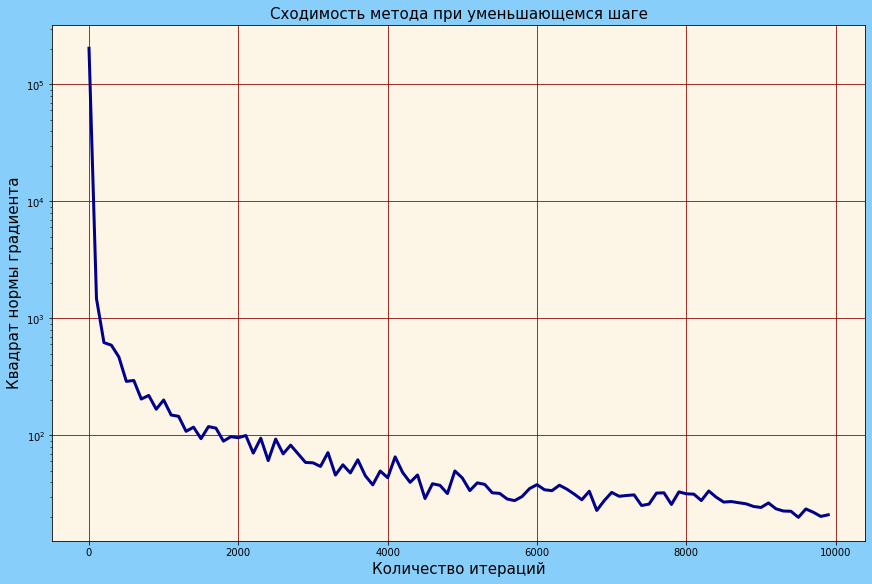

In [10]:
fg = plt.figure(figsize=(12, 8), constrained_layout=True, facecolor = "lightskyblue")
fig_ax_1 = fg.add_subplot(facecolor = "oldlace")
fig_ax_1.plot(values_x_2[::100], values_y_2[::100], 'darkblue', linewidth=3)
#fig_ax_1.legend(loc="upper right", fontsize=15)
fig_ax_1.semilogy()
fig_ax_1.set_xlabel("Количество итераций", fontsize=15)
fig_ax_1.set_ylabel("Квадрат нормы градиента", fontsize=15)
fig_ax_1.set_title('Сходимость метода при уменьшающемся шаге', fontsize=15)
fig_ax_1.grid(color='darkred')

Добавим батчирование:

In [11]:
def gradient_descent_stokh_3(start, n_iter, number):
    values_x = []
    values_y = []
    vector = start
    vector_list = []
    begin_time = time.time()
    timeprogGDP = []
    grad = gradient(vector)
    for i in range(n_iter):
        ksi = np.random.normal(0, 10, number)
        ksi = np.mean(ksi) * np.ones(d)
        vector = vector - 10/L/(i+10) * (grad  + ksi)
        grad = gradient(vector)
        values_x.append(i+1)
        values_y.append(grad.T.dot(grad))
        vector_list.append(vector)
        timeprogGDP.append(time.time() - begin_time)
    return values_x, values_y, vector, timeprogGDP

values_x_3, values_y_3, vector_3, timeprogGDP_3 = gradient_descent_stokh_3(np.ones(d)/d, 10000, 10)
values_x_4, values_y_4, vector_4, timeprogGDP_4 = gradient_descent_stokh_3(np.ones(d)/d, 10000, 100)

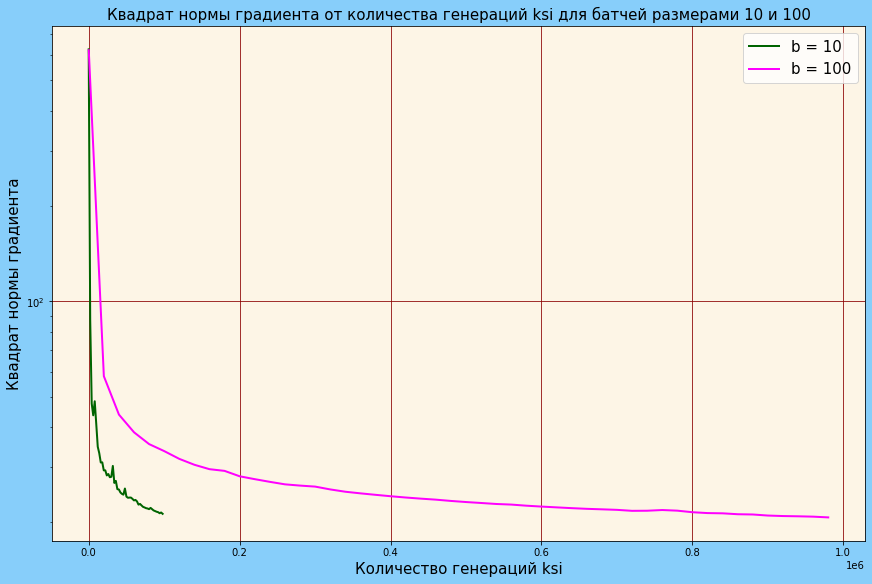

In [12]:
values_x_3_1 = np.copy(values_x_3)
values_x_4_1 = np.copy(values_x_4)
values_x_3_1 = 10 * values_x_3_1
values_x_4_1 = 100 * values_x_4_1

fg = plt.figure(figsize=(12, 8), constrained_layout=True, facecolor = "lightskyblue")
fig_ax_1 = fg.add_subplot(facecolor = "oldlace")
fig_ax_1.plot(values_x_3_1[::200], values_y_3[::200], 'darkgreen', label = 'b = 10', linewidth=2)
fig_ax_1.plot(values_x_4_1[::200], values_y_4[::200], 'magenta', label = 'b = 100', linewidth=2)
fig_ax_1.legend(loc="upper right", fontsize=15)
fig_ax_1.semilogy()
fig_ax_1.set_xlabel("Количество генераций ksi", fontsize=15)
fig_ax_1.set_ylabel("Квадрат нормы градиента", fontsize=15)
fig_ax_1.set_title('Квадрат нормы градиента от количества генераций ksi для батчей размерами 10 и 100', fontsize=15)
fig_ax_1.grid(color='darkred')

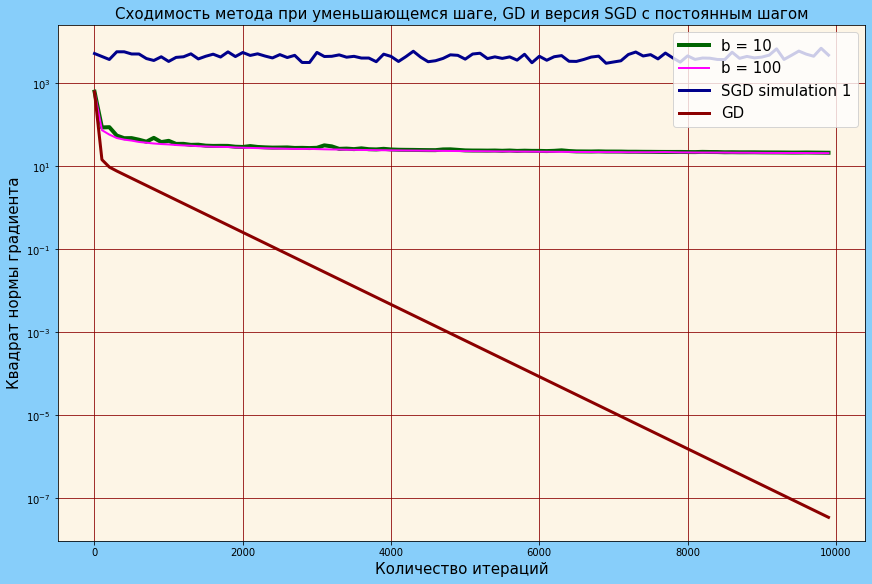

In [13]:
fg = plt.figure(figsize=(12, 8), constrained_layout=True, facecolor = "lightskyblue")
fig_ax_1 = fg.add_subplot(facecolor = "oldlace")
fig_ax_1.plot(values_x_3[::100], values_y_3[::100], 'darkgreen', label = 'b = 10', linewidth=4)
fig_ax_1.plot(values_x_4[::100], values_y_4[::100], 'magenta', label = 'b = 100', linewidth=2)
fig_ax_1.plot(values_x_1[::100], values_y_1[::100], 'darkblue', label = 'SGD simulation 1', linewidth=3)
fig_ax_1.plot(values_x[::100], values_y[::100], 'darkred', label = 'GD', linewidth=3)
fig_ax_1.legend(loc="upper right", fontsize=15)
fig_ax_1.semilogy()
fig_ax_1.set_xlabel("Количество итераций", fontsize=15)
fig_ax_1.set_ylabel("Квадрат нормы градиента", fontsize=15)
fig_ax_1.set_title('Сходимость метода при уменьшающемся шаге, GD и версия SGD с постоянным шагом', fontsize=15)
fig_ax_1.grid(color='darkred')

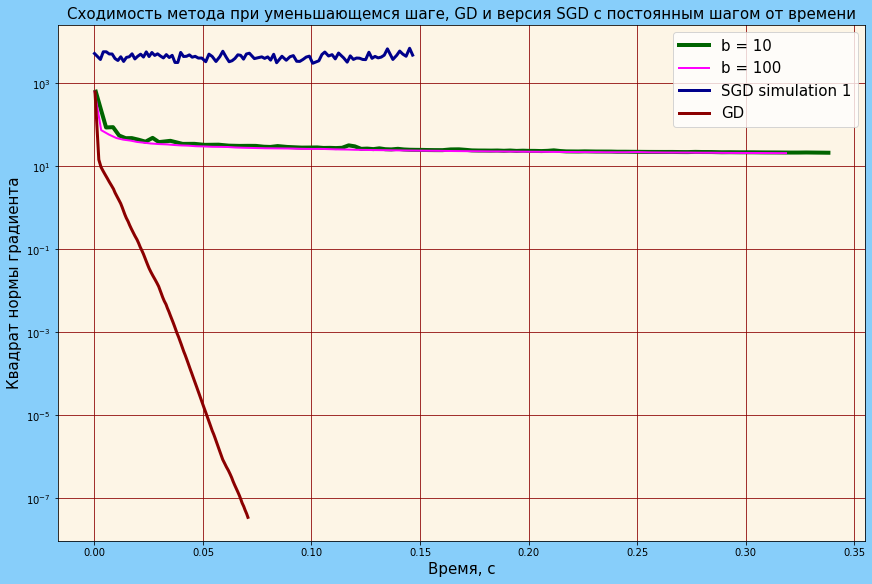

In [14]:
fg = plt.figure(figsize=(12, 8), constrained_layout=True, facecolor = "lightskyblue")
fig_ax_1 = fg.add_subplot(facecolor = "oldlace")
fig_ax_1.plot(timeprogGDP_3[::100], values_y_3[::100], 'darkgreen', label = 'b = 10', linewidth=4)
fig_ax_1.plot(timeprogGDP_4[::100], values_y_4[::100], 'magenta', label = 'b = 100', linewidth=2)
fig_ax_1.plot(timeprogGDP_1[::100], values_y_1[::100], 'darkblue', label = 'SGD simulation 1', linewidth=3)
fig_ax_1.plot(timeprogGDP[::100], values_y[::100], 'darkred', label = 'GD', linewidth=3)
fig_ax_1.legend(loc="upper right", fontsize=15)
fig_ax_1.semilogy()
fig_ax_1.set_xlabel("Время, с", fontsize=15)
fig_ax_1.set_ylabel("Квадрат нормы градиента", fontsize=15)
fig_ax_1.set_title('Сходимость метода при уменьшающемся шаге, GD и версия SGD с постоянным шагом от времени', fontsize=15)
fig_ax_1.grid(color='darkred')

### Вывод. 
Данная симуляция показала лучший результат, нежели первая. Однако все еще градиентный спуск показывает лучший результат как по количеству итераций, так и по времени.

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). Как мы знаем, эта задача имеет вид конечной суммы:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{n} \sum\limits_{j=1}^n f_j(w) := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b f_{ji}(w)\right] := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_i), y_i)\right],
\end{equation}
где $nb = N$ - полный размер выборки. Решите данную задачу с помощью SGD, SAGA (секция А.5 из [работы](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (секция А.9 из [работы](https://arxiv.org/pdf/1905.11261.pdf)) и SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. Обратите внимание, что теория для SAGA, SVRG, SARAH предполагает, что $L$ - это константа Липшица градиентов $\nabla f_j$. 

In [15]:
dataset = "mushrooms.txt" 

data = load_svmlight_file(dataset)
X_all, y_all = data[0].toarray(), data[1]
n_all, d_all = X_all.shape
#print(y)
for i in range (len(y_all)):
    if (y_all[i] == 2):
        y_all[i] = -1
#print(y)
X, X_test, y, y_test = train_test_split(X_all, y_all, train_size=0.81, random_state=42)

#####
N, d = X.shape
b = int(20)
b1 = int(20)
n = int(N / b)
#####
L = np.linalg.eigvals(1/(2*n)*X.T.dot(X))[0]
x_0 = np.linalg.pinv(X) @ y

X_sample = np.random.randint(0, N, b)
print(X_sample)
X_batch = X[X_sample]
Y_batch = y[X_sample]

L = 1/b * 2 * max(np.linalg.eigvalsh((X_batch.T@X_batch + 2 * L/1000 * np.identity(d))))
print(f"L = {L} \n")
mu = 1/b * 2  * min(np.linalg.eigvalsh((X_batch.T@X_batch + 2 * L/1000 * np.identity(d))))
print(f"mu = {mu} \n")

[ 746 6122 5351 2496 4878 4573 4115 1546 1142 5453 1736 4981 3192 2293
 2375 4407 4426 1180 4650 3562]
L = 22.06133721942577 

mu = 0.004412267443883708 



__(б)__ Реализуйте SGD, SAGA, SVRG, SARAH для задачи логистической регресии из $n$ слагаемых, где каждое слагаемое так же имеет виды суммы размеры $b$. Каким надо взять $b$? Почему? Что об этом говорит теория? Как будете выбирать шаг и другие параметры методов?

Величину b нужно выбирать так, чтобы она была сильно меньше, чем полная размерность (d). Тогда можно будет говорить, что одна итерация требует $O(1)$ подсчетов компонент градиента. Если же выбрать b слишком большой, но это уже будет не модификация SGD, а скорее модификация GD с неполным подсчетом градиента. Из статей получаем, что хорошо взять b = 20. Шаг выберем из опытов (например, для SAGA и SVRG: $\gamma ^* = \frac{0.8}{L}$).

Сформируем батчи: 

#### Имплементируем 4 метода.  Построим графики

In [16]:
def precision(x):
    schett = 0
    for j in range(len(y_test)):
        aaa = (y_test[j])*((x.dot(X_test[j])))
        if (aaa) < 0:
            schett += 1
    return (len(y_test) - schett)/(len(y_test))*100

def create_batches():
    yourList = list(range(N))
    B = sorted(yourList, key=lambda A: random.random())
    c = 0
    Batches=[[0]*b for i in range (n)]
    for i in range (n):
        for j in range (b):
            #print(i, j)
            Batches[i][j]=B[c]
            c+=1
    return (Batches)
Batches = create_batches()

def coord_gradient_batch(omega, batch):
    Z = []
    y_new = []
    for i in batch:
        Z.append(X[i])
        y_new.append(y[i])
    Z = np.array(Z)
    return 2*(Z.T.dot(Z.dot(omega) - y_new))/b

def gradient_batch(num, omega): 
    Z = []
    y_new = []
    for i in Batches[num]:
        Z.append(X[i])
        y_new.append(y[i])
    Z = np.array(Z)
    return 2*(Z.T.dot(Z.dot(omega) - y_new))/b

def gradient(omega): 
    return 2*(X.T.dot(X.dot(omega) - y))/N


In [18]:
def SAGA(start, n_iter, gamma, llambda):
    values_x = []
    values_y = []
    vector = np.copy(start)
    begin_time = time.time()
    timeprog_saga = []
    vector_list = []
    grad_calls = n + 1
    gradientt = []
    for i in range(n):
        gradientt.append(gradient_batch(i, vector))
    grad = np.sum(gradientt, axis = 0)/n
    #print(grad)
    for i in range(n_iter + 1):
        vector = (vector - gamma*grad)
        vector_new = np.copy(vector)
        k = random.randrange(0,n)
        gradientt[k] = gradient_batch(k, vector)
        grad = np.sum(gradientt, axis = 0)/n
        grad_calls += 1
        if (i % 10) == 0:
            vector_list.append(vector_new)
            values_x.append(grad_calls)
            timeprog_saga.append(time.time() - begin_time)
    return values_x, vector_list, timeprog_saga

values_x_saga, vector_list_saga, timeprogGDP_saga = SAGA(np.zeros(d), 300000, 0.8/L, L/1000)
values_y_saga = []
precision_list_saga = []
for i in range (len(vector_list_saga)):
    precision_list_saga.append(precision(vector_list_saga[i]))
    grad = gradient(vector_list_saga[i])
    values_y_saga.append(grad.T.dot(grad))

In [19]:
def SVRG(start, n_iter, gamma, llambda):
    values_x = []
    vector = np.copy(start)
    begin_time = time.time()
    timeprog_saga = []
    vector_list = []
    grad_calls = n
    g = gradient(vector)
    grad = np.copy(g)
    #print(grad)
    for i in range(n_iter + 1):
        vector = (vector - gamma*grad)
        vector_new = np.copy(vector)
        if (i % 100) == 0:
            vector2 = np.copy(vector)
            g = np.copy(gradient(vector2))
            grad = np.copy(g)
            grad_calls += n
        else:
            k = random.randrange(0,n)
            grad1 = gradient_batch(k, vector) 
            grad2 = gradient_batch(k, vector2)  
            grad = (g + grad1 - grad2)
            grad_calls += 2
        if (i % 10) == 0:
            vector_list.append(vector_new)
            values_x.append(grad_calls)
            timeprog_saga.append(time.time() - begin_time)
        
    return values_x, vector_list, timeprog_saga

values_x_svrg, vector_list_svrg, timeprogGDP_svrg = SVRG(np.zeros(d), 100000, 0.8/L, L/1000)
values_y_svrg = []
precision_list_svrg = []
for i in range (len(vector_list_svrg)):
    precision_list_svrg.append(precision(vector_list_svrg[i]))
    grad = gradient(vector_list_svrg[i])
    values_y_svrg.append(grad.T.dot(grad))
    

In [20]:
def SARAH(start, n_iter, gamma, llambda):
    values_x = []
    values_y = []
    vector = np.copy(start)
    begin_time = time.time()
    timeprog = []
    vector_list = []
    grad_calls = n
    g = gradient(vector)
    vector_old = np.copy(vector)
    #print(grad)
    for i in range(n_iter + 1):
        vector = (vector - gamma*g)
        vector_new = np.copy(vector)
        if (i % 100) == 0:
            g = np.copy(gradient(vector))
            grad_calls += n
        else:
            k = random.randrange(0,n)
            grad1 = gradient_batch(k, vector) 
            grad2 = gradient_batch(k, vector_old)  
            g = (g + grad1 - grad2)
            grad_calls += 2
        if (i % 10) == 0:
            vector_list.append(vector_new)
            values_x.append(grad_calls)
            timeprog.append(time.time() - begin_time)
        vector_old = np.copy(vector)
    return values_x, vector_list, timeprog

values_x_sarah, vector_list_sarah, timeprogGDP_sarah = SARAH(np.zeros(d), 100000, 0.08/L, L/1000)
values_y_sarah = []
precision_list_sarah = []
for i in range (len(vector_list_sarah)):
    precision_list_sarah.append(precision(vector_list_sarah[i]))
    grad = gradient(vector_list_sarah[i])
    values_y_sarah.append(grad.T.dot(grad))

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество подсчетов $\nabla f_{ji}$, по оси $y$ - $\|\nabla f(w^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [28]:
def coord_gradient_batch(omega, batch):
    Z = []
    y_new = []
    for i in batch:
        Z.append(X[i])
        y_new.append(y[i])
    Z = np.array(Z)
    return 2*(Z.T.dot(Z.dot(omega) - y_new))/len(batch)


def SGD_dependent(start, learn_rate, n_iter):
    values_x = []
    vector = start
    vector_list = []
    begin_time = time.time()
    timeprog = []
    schet = 0
    grad_calls = 0
    batches = create_batches()
    for i in range(n_iter):
        j = batches[schet]
        stokh_grad = coord_gradient_batch(vector, j)
        grad_calls += 1
        vector = vector - learn_rate * (stokh_grad)
        if (i % 10) == 0:
            vector_list.append(vector)
            values_x.append(grad_calls)
            timeprog.append(time.time() - begin_time)
        if (schet == len(batches) - 1):
            batches = create_batches()
            schet = 0
        else:
            schet += 1
        
        #print(schet)
    return values_x, vector_list, timeprog

values_x_sgd, vector_list_sgd, timeprogGDP_sgd = SGD_dependent(np.zeros(d), 0.002/(L), 500000)
values_y_sgd = []
precision_list_sgd = []
for i in range (len(vector_list_sgd)):
    precision_list_sgd.append(precision(vector_list_sgd[i]))
    grad = gradient(vector_list_sgd[i])
    values_y_sgd.append(grad.T.dot(grad))


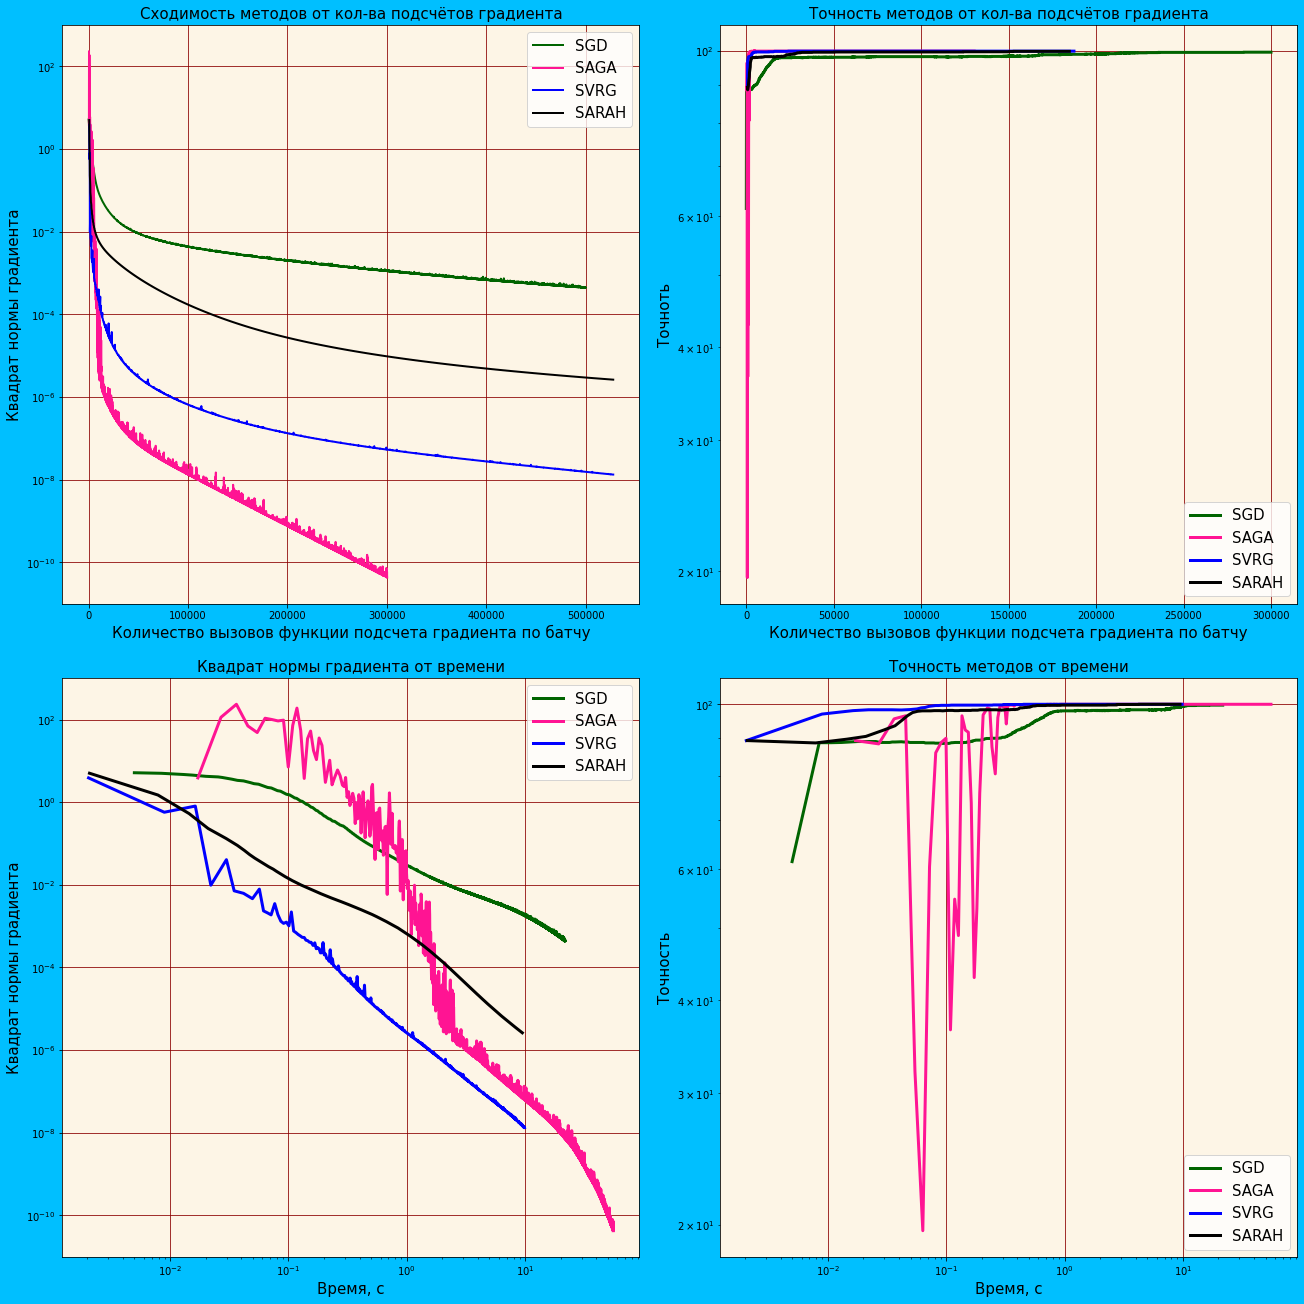

In [37]:
fg = plt.figure(figsize=(18, 18), constrained_layout=True, facecolor = "deepskyblue")
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fg)

fig_ax_1 = fg.add_subplot(gs[0, 0], facecolor = "oldlace")
fig_ax_1.plot(values_x_sgd[::5], values_y_sgd[::5], 'darkgreen', label = 'SGD', linewidth=2)
fig_ax_1.plot(values_x_saga[::5], values_y_saga[::5], 'deeppink', label = 'SAGA', linewidth=2)
fig_ax_1.plot(values_x_svrg[::5], values_y_svrg[::5], 'blue', label = 'SVRG', linewidth=2)
fig_ax_1.plot(values_x_sarah[::5], values_y_sarah[::5], 'black', label = 'SARAH', linewidth=2)
fig_ax_1.legend(loc="upper right", fontsize=15)
fig_ax_1.semilogy()
fig_ax_1.set_xlabel('Количество вызовов функции подсчета градиента по батчу', fontsize=15)
fig_ax_1.set_ylabel("Квадрат нормы градиента", fontsize=15)
fig_ax_1.set_title('Сходимость методов от кол-ва подсчётов градиента', fontsize=15)
fig_ax_1.grid(color='darkred')
############################################################

fig_ax_2 = fg.add_subplot(gs[0, 1], facecolor = "oldlace")
fig_ax_2.plot(values_x_sgd[:30000:5], precision_list_sgd[:30000:5], 'darkgreen', label = 'SGD', linewidth=3)
fig_ax_2.plot(values_x_saga[:13000:5], precision_list_saga[:13000:5], 'deeppink', label = 'SAGA', linewidth=3)
fig_ax_2.plot(values_x_svrg[:3550:5], precision_list_svrg[:3550:5], 'blue', label = 'SVRG', linewidth=3)
fig_ax_2.plot(values_x_sarah[:3500:5], precision_list_sarah[:3500:5], 'black', label = 'SARAH', linewidth=3)
fig_ax_2.legend(loc="lower right", fontsize=15)
fig_ax_2.semilogy()
#fig_ax_2.loglog()
fig_ax_2.set_xlabel('Количество вызовов функции подсчета градиента по батчу', fontsize=15)
fig_ax_2.set_ylabel("Точноть", fontsize=15)
fig_ax_2.set_title('Точность методов от кол-ва подсчётов градиента', fontsize=15)
fig_ax_2.grid(color='darkred')
############################################################

fig_ax_3 = fg.add_subplot(gs[1, 0], facecolor = "oldlace")
fig_ax_3.plot(timeprogGDP_sgd[::5], values_y_sgd[::5], 'darkgreen', label = 'SGD', linewidth=3)
fig_ax_3.plot(timeprogGDP_saga[::5], values_y_saga[::5], 'deeppink', label = 'SAGA', linewidth=3)
fig_ax_3.plot(timeprogGDP_svrg[::5], values_y_svrg[::5], 'blue', label = 'SVRG', linewidth=3)
fig_ax_3.plot(timeprogGDP_sarah[::5], values_y_sarah[::5], 'black', label = 'SARAH', linewidth=3)
fig_ax_3.legend(loc="upper right", fontsize=15)
#fig_ax_3.semilogy()
fig_ax_3.loglog()
fig_ax_3.set_xlabel('Время, с', fontsize=15)
fig_ax_3.set_ylabel("Квадрат нормы градиента", fontsize=15)
fig_ax_3.set_title('Квадрат нормы градиента от времени', fontsize=15)
fig_ax_3.grid(color='darkred')
############################################################

fig_ax_4 = fg.add_subplot(gs[1, 1], facecolor = "oldlace")
fig_ax_4.plot(timeprogGDP_sgd[::5], precision_list_sgd[::5], 'darkgreen', label = 'SGD', linewidth=3)
fig_ax_4.plot(timeprogGDP_saga[::5], precision_list_saga[::5], 'deeppink', label = 'SAGA', linewidth=3)
fig_ax_4.plot(timeprogGDP_svrg[::5], precision_list_svrg[::5], 'blue', label = 'SVRG', linewidth=3)
fig_ax_4.plot(timeprogGDP_sarah[::5], precision_list_sarah[::5], 'black', label = 'SARAH', linewidth=3)
fig_ax_4.legend(loc="lower right", fontsize=15)
#fig_ax_4.semilogy()
fig_ax_4.loglog()
fig_ax_4.set_xlabel('Время, с', fontsize=15)
fig_ax_4.set_ylabel("Точность", fontsize=15)
fig_ax_4.set_title('Точность методов от времени', fontsize=15)
fig_ax_4.grid(color='darkred')

## Вывод:
Получена сходимость методов.

SVRG и SARAH сходятся быстрее всего и устойчивее. SGD сходится медленнее, чем остальные методы.
По точности самые быстрый по времени - SVRG,по подсчетам градиента - SVRG, SAGA. 

__Бонусные пункты__

__(г)__ Методы SGD, SAGA, SVRG, SARAH, которые мы рассматривали, предполагают случайный выбор индекса на каждой итерации. Но между тем, на практике обычно делают по-другому и просто последовательно меняют $i_k$ от $1$ до $n$ (а потом заново). В [работе](https://arxiv.org/abs/2006.05988) изучаются такие подходы. Реализуйте Random Reshuffling и Shuffle Once для SGD и SARAH. Сравните новые алгоритмы со старыми версиями SGD и SARAH из пунктов (б) и (в).

In [ ]:
#ответ

__(д)__ Методы SVRG и SARAH имеют loopless версии: L-SVRG (секция А.10 из [работы](https://arxiv.org/pdf/1905.11261.pdf) и PAGE ([работа](https://proceedings.mlr.press/v139/li21a.html)), соотвественно. Реализуйте их. Как будете выбирать вероятности в этих алгоритмах? Сравните новые алгоритмы со старыми версиями SVRG и SARAH из пунктов (б) и (в).

In [ ]:
#ответ